In [1]:
%load_ext autoreload
%autoreload 2

## Apprentissage des aspect implicites

### Importation des bibliothèques

In [2]:
import os
os.chdir("..")

In [3]:
import copy
import numpy as np
from itertools import chain
from collections import Counter
import seaborn as sns
from collections import Counter
from time import time
from Preprocessors.ReviewPreprocessor import ReviewPreprocessor
from Aspects.ExplicitAspectExtractor import ExplicitAspectExtractor
from Aspects.CoRefAspectIdentGrouping import CoRefAspectIdentGrouping
from Aspects.ImplicitAspectExtractor import ImplicitAspectExtractor
import pandas as pd
import spacy
nlp = spacy.load("en_core_web_sm")

### Fonction de pretraitement des datasets

La fonction prend un dictionnaire de datasets. Le dictionnaire a comme clé un nom pour identifier le dataset et comme valeur le chemin vers le dataset.

In [4]:
def clean_datasets(datasets):
    cleaned_datasets = []
    for dataset_name in datasets:
        print(f"cleaning dataset {dataset_name}")
        dataset = pd.read_csv(datasets[dataset_name])
        old = time()
        review_preprocessor = ReviewPreprocessor(dataset['review'], nlp)
        dataset['cleaned_review'] = review_preprocessor.remove_tags()
        dataset['cleaned_review'] = review_preprocessor.lowercase_transformation()
        dataset['cleaned_review'] = review_preprocessor.pararel_spelling_correction()
        dataset['cleaned_review'] = review_preprocessor.remove_objective_sentences()
        dataset = dataset[dataset['cleaned_review'] != ""]
        print(f"cleaning {dataset_name} took {time() - old}")
        cleaned_datasets.append((dataset_name, dataset))
    return cleaned_datasets

### Application de prétraitement

Les jeux de données utilisés dans cette notebook sont collectés à l'aide de module de scraping créé pour le projet.

- les datasets **tripadvisor**, **booking** et **agoda** contient des commentaires de 10 hôtels à Paris, en total chaque dataset contient respectivement 2141, 1022, 230 commentaires.
- les datasets **agoda_london** et **tripadivsor_london** contient des commentaires de 5 hôtels à Londres, en total chaque dataset contient respectivement 245 et 658.

In [5]:
old = time()
datasets = {'tripadvisor': 'data/3 datasets/reviews_TripAdvisor_2022_5_20_11_27_56_ 10pages_10hotels.csv',
                    'booking': 'data/3 datasets/reviews_Booking_2022_5_20_11_9_54_10links_10_pages.csv',
                    'agoda': 'data/3 datasets/reviews_Agoda_2022_5_20_10_58_5_10pages_10_links.csv',
                    'agoda_london':'data/3 datasets/reviews_Agoda_2022_5_21_11_32_11_London_5pages_5links.csv',
                    'tripadvisor_london': 'data/3 datasets/reviews_TripAdvisor_2022_5_21_11_51_26_london_5pages_5links.csv'}
cleaned_datasets = clean_datasets(datasets)
print(f"duration : {time() - old}")

cleaning dataset tripadvisor


2141it [00:54, 39.14it/s]


cleaning tripadvisor took 220.08430528640747
cleaning dataset booking


1022it [00:13, 75.85it/s]


cleaning booking took 34.807780504226685
cleaning dataset agoda


230it [00:02, 77.05it/s]


cleaning agoda took 16.60640048980713
cleaning dataset agoda_london


245it [00:03, 71.36it/s]


cleaning agoda_london took 23.384303331375122
cleaning dataset tripadvisor_london


658it [00:27, 24.14it/s]

cleaning tripadvisor_london took 77.62373113632202
duration : 372.99679613113403


### Application d'extraction des aspects explicites.

In [6]:
file = open("explicit_aspects.txt" ,"r")
aspects = file.readline()
print(aspects)
file.close()

{'room': 9.336769065918787, 'hotel': 9.318147375905292, 'staff': 4.888445740765635, 'breakfast': 3.829487624528798, 'location': 3.5532388967548627, 'restaurant': 1.5790745196187395, 'stay': 1.5439995345484352, 'night': 1.5216695736407224, 'bed': 1.4378734998656602, 'service': 1.4095849058175376, 'area': 1.3211768956239531, 'bathroom': 1.173482928395186, 'time': 1.164096232386624, 'drink': 1.1028630610824863, 'bar': 1.0989040537225405, 'place': 0.9786827060640071, 'snack': 0.8997133255097571, 'tower': 0.8797069280801819, 'metro': 0.8218407962276851, 'reception': 0.8085499548836076, 'shower': 0.8058491756146875, 'coffee': 0.7851454458555878, 'station': 0.7809855056483224, 'water': 0.6615235236610075, 'food': 0.6257220299972334, 'price': 0.5913045347836622, 'street': 0.5890662484492425, 'view': 0.5712408161854151, 'distance': 0.5700379243599084, 'desk': 0.5605801789401762, 'garden': 0.4990240426264071, 'experience': 0.4612699699448825, 'trip': 0.4373309081739345, 'lobby': 0.42772438374491

### Construction de la matrice de co-occurrence pour chaque dataset

In [7]:
co_occurrence_matrixes = []
for i, cleaned_d in enumerate(cleaned_datasets):
    print(f"creating cooccurrence matrix for {cleaned_d[0]}")
    cleaned_d[1].rename(columns = {'cleaned_data':'cleaned_review'}, inplace= True)
    co_ref_obj = CoRefAspectIdentGrouping(cleaned_d[1], eval(aspects), nlp)
    old = time()
    co_occurrence_matrix = co_ref_obj.get_co_occurrence_matrix()
    co_occurrence_matrixes.append((cleaned_d[0], co_occurrence_matrix))
    print(f"duration to construct co-occurence matrix of {cleaned_d[0]} dataset is {time() - old}s")

creating cooccurrence matrix for tripadvisor
duration to construct co-occurence matrix of tripadvisor dataset is 80.32940435409546s
creating cooccurrence matrix for booking
duration to construct co-occurence matrix of booking dataset is 12.430433511734009s
creating cooccurrence matrix for agoda
duration to construct co-occurence matrix of agoda dataset is 2.7852649688720703s
creating cooccurrence matrix for agoda_london
duration to construct co-occurence matrix of agoda_london dataset is 3.613072395324707s
creating cooccurrence matrix for tripadvisor_london
duration to construct co-occurence matrix of tripadvisor_london dataset is 18.707362413406372s


In [8]:
shared_aspects = set.intersection(set(co_occurrence_matrixes[0][1].columns),
                                  set(co_occurrence_matrixes[1][1].columns),
                                  set(co_occurrence_matrixes[2][1].columns),
                                  set(co_occurrence_matrixes[3][1].columns),
                                  set(co_occurrence_matrixes[4][1].columns))
len(shared_aspects)

56

il a 56 aspects explicites communs entre les cinq dataset

#### les adjectifs partagés entre les matrices de cooccurrences

In [9]:
len(set.intersection(set(co_occurrence_matrixes[0][1].index), set(co_occurrence_matrixes[1][1].index), set(co_occurrence_matrixes[2][1].index), set(co_occurrence_matrixes[3][1].index), set(co_occurrence_matrixes[4][1].index)))

106

Il y a 106 adjectifs communs entre les 5 matrices de cooccurrences. Ce nombre est bas car il est influencé par les datasets avec moins d'adjectifs.

#### les adjectifs non partagés entre les matrices de cooccurrences.

In [10]:
adjs = [set(co_occurrence_matrixes[0][1].index),
        set(co_occurrence_matrixes[1][1].index),
        set(co_occurrence_matrixes[2][1].index),
        set(co_occurrence_matrixes[3][1].index),
        set(co_occurrence_matrixes[4][1].index)]

freq = Counter(chain.from_iterable(adjs))

res = {idx for idx in freq if freq[idx] == 1}

In [11]:
len(res)

860

il y a 860 adjectifs non partagé (existe dans une seul matrice, mais n'est pas dans les autres).

#### Porcentage des adjs non partagé dans chaque dataset

In [12]:
len(res & set(co_occurrence_matrixes[0][1].index)) / len(res) * 100

68.95348837209302

68.95% des adjs non partagés sont dans le dataset **tripadvisor** qui contient 2141 commentaires.

In [13]:
len(res & set(co_occurrence_matrixes[1][1].index)) / len(res) * 100

7.093023255813953

Le dataset **booking** (1022 commentaires) contient 7% des adjs non partagés.

In [14]:
len(res & set(co_occurrence_matrixes[2][1].index)) / len(res) * 100

1.2790697674418605

1.3% des adjectifs non partagés sont dans le dataset **agoda** qui contient 230 commentaires.

In [15]:
len(res & set(co_occurrence_matrixes[3][1].index)) / len(res) * 100

3.8372093023255816

Le jeu de données **agoda_london** (245 commentaires) participe avec un pourcentage de 3.8% dans la liste des adjectifs non partagés.

In [16]:
len(res & set(co_occurrence_matrixes[4][1].index)) / len(res) * 100

18.83720930232558

Le jeu de données **tripadvisor_london** contient 18.8% des adjs non partagés.

### Calcule des proportions

la relation utilisé pour calculer les proportions de chaque aspect dans un adjectif est:

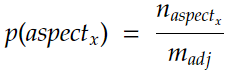

avec:
- **n** nombre d'occurence de l'aspect 
- **m** le nombre d'occurence de l'adjective

In [17]:
prop_matrixes = copy.deepcopy(co_occurrence_matrixes)
for i in range(0,5):
    matrix = prop_matrixes[i][1]
    for adj in list(matrix.index):
        occurences_sum = matrix.loc[adj].sum(axis=0)
        for aspect in list(matrix.columns):
            matrix.loc[adj, aspect] = matrix.at[adj, aspect]/occurences_sum

jeu de données **tripadvisor**

In [18]:
prop_matrixes[0][1]*100

,room,hotel,staff,breakfast,location,restaurant,stay,night,bed,service,...,facility,minibar,manager,balcony,towel,tv,courtyard,dinner,member,parking
small,31.822070,12.403764,3.250642,3.592814,2.224123,2.053037,1.112062,1.026518,2.737382,0.855432,...,0.256630,0.598802,0.085543,1.112062,0.256630,0.598802,0.684346,0.085543,0.25663,0.513259
comfortable,28.636884,9.163803,5.498282,3.780069,2.978236,1.030928,2.520046,2.405498,17.869416,2.061856,...,0.229095,0.343643,0.000000,0.572738,0.229095,0.229095,0.458190,0.000000,0.00000,0.000000
hot,12.012012,6.306306,2.402402,12.312312,0.900901,0.600601,1.201201,5.105105,1.501502,0.900901,...,0.000000,0.000000,0.300300,0.300300,0.000000,0.300300,0.000000,0.000000,0.30030,0.000000
good,10.316847,11.978362,5.950541,12.094281,9.003091,4.057187,1.506955,1.506955,2.086553,3.554869,...,0.347759,0.463679,0.193199,0.309119,0.154560,0.270479,0.193199,0.193199,0.15456,0.077280
simple,11.428571,5.714286,2.857143,25.714286,8.571429,2.857143,2.857143,0.000000,5.714286,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
linger,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
ambient,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
minimalistic,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
overgrown,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


jeu de données **booking**

In [19]:
prop_matrixes[1][1]*100

,room,hotel,staff,breakfast,location,restaurant,stay,night,bed,service,...,facility,minibar,manager,balcony,towel,tv,courtyard,dinner,member,parking
pathetic,0.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,50.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
faulty,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
few,13.157895,18.421053,2.631579,5.263158,5.263158,5.263158,0.000000,2.631579,5.263158,2.631579,...,0.000000,2.631579,2.631579,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
fantastic,0.000000,12.500000,25.000000,12.500000,12.500000,0.000000,0.000000,0.000000,0.000000,12.500000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
great,12.669683,4.977376,9.502262,8.144796,20.814480,2.714932,0.452489,1.809955,3.167421,2.714932,...,1.357466,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.452489,1.357466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
stinky,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
accommodating,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
blue,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
sensitive,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


jeu de données **agoda**

In [20]:
prop_matrixes[2][1]*100

,room,hotel,staff,breakfast,location,restaurant,stay,night,bed,service,...,facility,minibar,manager,balcony,towel,tv,courtyard,dinner,member,parking
professional,0.000000,0.000000,33.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
first,13.333333,13.333333,6.666667,0.000000,0.000000,0.000000,0.000000,6.666667,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
friendly,8.108108,10.810811,51.351351,2.702703,2.702703,2.702703,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
important,50.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nice,13.636364,11.363636,25.000000,4.545455,9.090909,2.272727,2.272727,2.272727,0.0,0.0,...,0.0,0.0,2.272727,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cooperative,50.000000,0.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
deficient,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,100.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
quiet,20.000000,0.000000,20.000000,0.000000,20.000000,0.000000,20.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
stuffy,33.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


jeu de données **agoda_london**

In [21]:
prop_matrixes[3][1]*100

,room,hotel,staff,breakfast,location,restaurant,stay,night,bed,service,...,facility,minibar,manager,balcony,towel,tv,courtyard,dinner,member,parking
terrible,12.500000,25.000000,6.25,6.25,0.000000,6.250000,0.0,6.250000,6.25,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bad,10.526316,36.842105,0.00,0.00,10.526316,5.263158,0.0,10.526316,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
horrendous,0.000000,100.000000,0.00,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
naked,100.000000,0.000000,0.00,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
drunk,33.333333,0.000000,0.00,0.00,0.000000,0.000000,0.0,33.333333,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
professional,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.0,0.000000,0.00,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
intrusive,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.0,0.000000,0.00,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
extra,50.000000,50.000000,0.00,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
eld,0.000000,0.000000,50.00,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


jeu de données **tripadvisor_london**

In [22]:
prop_matrixes[4][1]*100

,room,hotel,staff,breakfast,location,restaurant,stay,night,bed,service,...,facility,minibar,manager,balcony,towel,tv,courtyard,dinner,member,parking
lovely,14.925373,14.328358,10.447761,4.477612,4.776119,1.492537,3.880597,0.597015,2.985075,2.686567,...,0.597015,0.0,0.000000,0.298507,0.597015,0.298507,0.0,2.985075,0.597015,0.0
quiet,29.850746,8.955224,4.477612,0.000000,5.970149,0.000000,4.477612,7.462687,7.462687,1.492537,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
efficient,10.714286,10.714286,17.857143,0.000000,7.142857,7.142857,0.000000,0.000000,0.000000,7.142857,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
friendly,7.282913,10.924370,37.815126,3.361345,3.921569,1.400560,2.240896,1.120448,0.000000,3.921569,...,0.560224,0.0,0.280112,0.000000,0.000000,0.000000,0.0,0.840336,2.240896,0.0
quick,4.545455,27.272727,4.545455,0.000000,4.545455,4.545455,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,4.545455,9.090909,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vicente,0.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
canary,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
brown,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
seperate,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0


In [23]:
all_aspects = set.union(set(co_occurrence_matrixes[0][1].columns), set(co_occurrence_matrixes[1][1].columns), set(co_occurrence_matrixes[2][1].columns), set(co_occurrence_matrixes[3][1].columns), set(co_occurrence_matrixes[4][1].columns))

In [24]:
shared_aspects = set.intersection(set(co_occurrence_matrixes[0][1].columns), set(co_occurrence_matrixes[1][1].columns), set(co_occurrence_matrixes[2][1].columns), set(co_occurrence_matrixes[3][1].columns), set(co_occurrence_matrixes[4][1].columns))

In [25]:
shared_adjs = set.intersection(set(co_occurrence_matrixes[0][1].index), set(co_occurrence_matrixes[1][1].index), set(co_occurrence_matrixes[2][1].index), set(co_occurrence_matrixes[3][1].index), set(co_occurrence_matrixes[4][1].index))

### Calcule de variance pour les couples (adjectif, aspect)

Dans cette partie, nous calculons la variance entre les proportions des couple (adjectif, aspect) dans les cinq datasets.

In [26]:
variance_adjs_aspects_matrixes = pd.DataFrame(index=shared_adjs, columns=shared_aspects)
for shared_adj in shared_adjs:
    for aspect in all_aspects:
        values = np.array([])
        for prop_matrix in prop_matrixes:
            try:
                values = np.append(values, prop_matrix[1].loc[shared_adj, aspect]*100)
            except KeyError:
                values = np.append(values, 0)
        variance_adjs_aspects_matrixes.loc[shared_adj, aspect] = values.var()

In [27]:
variance_adjs_aspects_matrixes

,buffet,breakfast,metro,drink,time,member,coffee,restaurant,lobby,balcony,...,place,bus,water,tv,access,dinner,desk,cafe,snack,luggage
major,0.0,0.17005,110.054447,0.0,0.17005,0.0,0.17005,14.846345,0.0,0.0,...,0.6802,392.432777,0.17005,0.0,33.728672,0.0,0.0,0.17005,0.0,400.0
fine,0.0,79.783046,0.396801,0.0992,1.721072,0.0992,0.396801,5.319381,0.0,0.0992,...,15.136958,0.0992,0.396801,1.298012,0.0,0.0,0.892802,0.0,0.396801,0.0
near,0.0,1.612497,25.501823,0.403124,0.0,0.0,0.0,11.239482,0.0,0.0,...,14.512472,10.503974,0.403124,0.0,11.871302,0.0,0.0,1.612497,0.403124,0.0
comfortable,0.008398,2.616111,0.24356,0.610963,0.982797,0.0,0.12183,1.83629,0.126363,0.052485,...,1.210292,2.000268,0.433495,0.06089,0.008398,0.0,0.04424,0.0,0.059498,0.002099
simple,0.0,83.270536,1.306122,0.0,77.254438,0.0,1.664932,56.501009,0.0,0.0,...,5.22449,0.0,1.306122,0.0,0.0,0.0,32.653061,1.664932,1.306122,1.664932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
kind,0.128698,12.869754,0.128698,0.289569,0.51479,36.894691,0.0,0.128698,0.0,0.032174,...,0.289569,19.753086,0.032174,7.111111,0.0,0.0,0.80436,0.0,0.032174,23.881811
least,6.25,28.45399,19.753086,0.756144,6.805293,0.0,6.25,0.756144,0.756144,0.0,...,0.756144,0.0,0.756144,0.0,0.756144,0.0,0.756144,0.0,0.756144,0.0
difficult,0.0,0.0,0.0,0.0,11.442472,0.0,0.378698,0.378698,0.0,0.0,...,0.378698,0.0,154.487837,0.0,1.514793,0.0,3.26693,0.0,0.0,149.376551
new,0.0,11.428254,0.189036,0.189036,29.379439,0.0,0.0,1.344255,0.0,0.0,...,11.428254,0.756144,0.0,0.189036,0.0,0.0,0.0,0.0,0.0,0.189036


#### vérification de calcule de variance

Pour vérifier le calcule de variance, nous choissons le coupe (nice, hotel).

**la variance calculé par le code ci-dessus**

In [28]:
variance_adjs_aspects_matrixes.loc['nice','hotel']

5.539770877609998

**proportion de couple (nice, hotel) dans les cinq dataset**

In [29]:
for i in range(0,5):
    print("dataset :", prop_matrixes[i][0], "/ proportion : ", prop_matrixes[i][1].loc['nice', 'hotel']*100)

dataset : tripadvisor / proportion :  15.0
dataset : booking / proportion :  9.541984732824428
dataset : agoda / proportion :  11.363636363636363
dataset : agoda_london / proportion :  16.0
dataset : tripadvisor_london / proportion :  13.262599469496022


In [30]:
np.array([15.0, 9.541984732824428, 11.363636363636363,16.0,13.262599469496022]).var()

5.539770877609998

**La valeur calculée ci-dessus est égale à celle calculée par le code dans la cellule 29.**

In [31]:
stacked_variance = variance_adjs_aspects_matrixes.stack()

In [32]:
stacked_variance.sort_values(ascending=False)

awful       location           1600.0
huge        luggage            1600.0
average     attraction         1600.0
impossible  place         1551.020408
pleasant    experience    1546.396689
                             ...     
hot         bus                   0.0
bad         buffet                0.0
            drink                 0.0
            lobby                 0.0
central     luggage               0.0
Length: 5936, dtype: object

In [33]:
len(stacked_variance[stacked_variance ==0].index)

1908

Il y a 1908 couples (adjectif, aspect) ont une variance égale à zéro.

**Remarques**

- les éléments avec une grande variance comme le couple ('underground', 'location'). ils ont des proportions dispersées.

In [34]:
for i in range(0,5):
    print("dataset :", prop_matrixes[i][0], "/ proportion : ", prop_matrixes[i][1].loc['underground', 'location']*100)

dataset : tripadvisor / proportion :  9.090909090909092
dataset : booking / proportion :  100.0
dataset : agoda / proportion :  0.0
dataset : agoda_london / proportion :  33.33333333333333
dataset : tripadvisor_london / proportion :  8.333333333333332


In [35]:
np.array([9.090909090909092,100,0.0,33.33333333333333,8.333333333333332]).var()

1343.526170798898

- les couples (adjectifs, aspects) qui ont une petite variance ont des valeurs de proportion proches entre eux ou proches de zéro. 

In [36]:
variance_adjs_aspects_matrixes.loc['clean','room']

0.9147768102438789

In [37]:
for i in range(0,5):
    print("dataset :", prop_matrixes[i][0], "/ proportion :", prop_matrixes[i][1].loc['clean', 'room']*100)

dataset : tripadvisor / proportion : 30.106183635227985
dataset : booking / proportion : 31.347962382445143
dataset : agoda / proportion : 30.434782608695656
dataset : agoda_london / proportion : 31.06796116504854
dataset : tripadvisor_london / proportion : 28.617363344051448


In [38]:
variance_adjs_aspects_matrixes.loc['double','food']

0.0

In [39]:
for i in range(0,5):
    print("dataset :", prop_matrixes[i][0], "/ proportion : ", prop_matrixes[i][1].loc['double', 'food']*100)

dataset : tripadvisor / proportion :  0.0
dataset : booking / proportion :  0.0
dataset : agoda / proportion :  0.0
dataset : agoda_london / proportion :  0.0
dataset : tripadvisor_london / proportion :  0.0


### Construction des condition de sélection

#### afficage de box plot

(-1.0, 50.0)

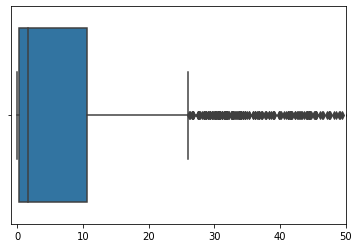

In [44]:
ax = sns.boxplot(stacked_variance[stacked_variance >0])
ax.set_xlim(stacked_variance.min()-1,50)

**la valeur de médian**

In [40]:
stacked_variance.median()

0.35642682111828905

**On choisit les couples (adj/aspect) avec une variance entre le médian et 3ème quantile**

In [91]:
adjs = set()
for i, item in stacked_variance[(stacked_variance>0.3) & (stacked_variance <12)].items():
    adjs.add(i[0])

In [92]:
print(adjs)

{'major', 'fine', 'near', 'comfortable', 'simple', 'tiny', 'convenient', 'french', 'dirty', 'cold', 'same', 'different', 'young', 'double', 'cozy', 'right', 'important', 'available', 'quick', 'tired', 'friendly', 'rude', 'amazing', 'clean', 'much', 'safe', 'short', 'efficient', 'ok', 'unhelpful', 'hard', 'last', 'first', 'few', 'large', 'only', 'happy', 'full', 'disappointing', 'close', 'average', 'little', 'great', 'helpful', 'next', 'nice', 'worth', 'quiet', 'extra', 'fair', 'basic', 'free', 'various', 'pleasant', 'warm', 'cheap', 'hot', 'bad', 'enough', 'dark', 'wonderful', 'well', 'delicious', 'decent', 'big', 'small', 'perfect', 'second', 'public', 'functional', 'impossible', 'surprised', 'empty', 'huge', 'long', 'okay', 'professional', 'easy', 'more', 'horrible', 'underground', 'modern', 'other', 'front', 'many', 'excellent', 'poor', 'good', 'twin', 'attentive', 'spacious', 'most', 'wrong', 'able', 'old', 'awful', 'awesome', 'own', 'fresh', 'fantastic', 'high', 'kind', 'least', '

In [98]:
len(adjs)

106

106 couples adj ont une variance satisfait la condition de sélection

In [93]:
filtred_stacked_variance = stacked_variance[(stacked_variance>0.3) & (stacked_variance <12)]

In [133]:
for adj in adjs:
    print(f"adjective : {adj}")
    print(filtred_stacked_variance[ filtred_stacked_variance == filtred_stacked_variance.loc[adj].max()][adj])
    print("==============")

adjective : major
trip     1.53045
area     1.53045
staff    1.53045
dtype: object
adjective : fine
shop    6.25
dtype: object
adjective : near
access    11.871302
dtype: object
adjective : comfortable
airport    8.304392
dtype: object
adjective : simple
facility    9.467456
check       9.467456
dtype: object
adjective : tiny
bed    8.596595
dtype: object
adjective : convenient
service    8.30839
dtype: object
adjective : french
bus    11.111111
dtype: object
adjective : dirty
bed    7.509293
dtype: object
adjective : cold
snack    11.518825
dtype: object
adjective : same
check      8.163265
towel      8.163265
luggage    8.163265
dtype: object
adjective : different
time    4.942352
dtype: object
adjective : young
facility    8.163265
dtype: object
adjective : double
area       10.165171
service    10.165171
dtype: object
adjective : cozy
breakfast    7.609988
dtype: object
adjective : right
breakfast    6.449987
metro        6.449987
dtype: object
adjective : important
stay       9.46

#### Remarque

- Après l'extraction les couples (adj/aspect) stables. les couples (fantastic, restaurant), (awesome, bar), (awesome, service), (tiny, bed), (horible, price) (horible, qualit), (spacious, hotel), (bad, service) ont des adjectifs généraux et qui peuvent être utilisés avec n'importe quel aspect bar exemple (bad, hotel) (bad, restaurant), (bad, location)
- le couple (fresh, food) peut être correct 
- il y a des couples avec le même adjectif comme (awful, stay), (awful, customer), (awful, service), dans ce cas il est difficile de déterminer l'aspect implicite.
- il y a des couple qui peuvent être erroné comme (central, staff), (difficult, time), (kind, airport), (unhelpful, bed), (unhelpful, food)

**Ainsi l'approche utilisée pour l'extraction des aspects implicites n'est pas performante, et par conséquent on propose de l'éliminé du modèle**

### Relations mathématiques

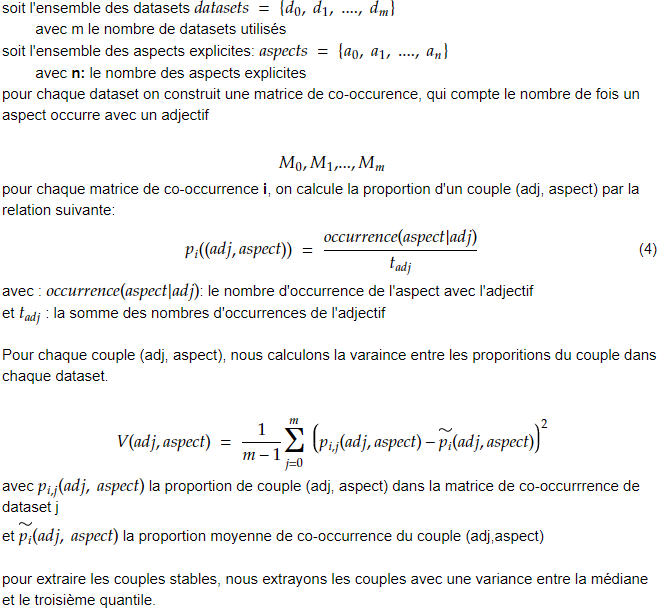